# Benchmark: Centroid computation

Benchmark comparing Minimum Bounding Rectangle computation across:

* [georust/geo](https://lib.rs/crates/geo) crate
* The [geos C library](https://trac.osgeo.org/geos/), used through high-level Rust bindings via the [geos](https://lib.rs/crates/geos) crate

## Benchmarked operation

Each iteration computes the centroid of the multi-polygon representing all districts of India a 100,000 times.

# Prerequisites

Generate data:

```bash
cd harness
cargo build --release
LD_LIBRARY_PATH="${LD_LIBRARY_PATH}:/mnt/data/source/explore-georust/third_party/lib/geos/relwithdebinfo" target/release/benchmark_centroid --out-file ../analysis/benchmark_centroid/data.json --geojson-file ../data/india_districts/polbnda_ind.geojson --headlong --iterations 120
```

### Loading data from /mnt/data/source/explore-georust/analysis/benchmark_centroid/data.json
### Statistics: Raw data
                qps            
program         geo        geos
count    110.000000  110.000000
mean      43.296538    0.896711
std        7.249960    0.136855
min        6.421094    0.444483
25%       44.287108    0.934798
50%       44.707892    0.942515
75%       45.715880    0.944883
max       46.052194    0.948411


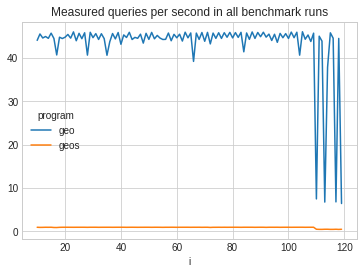

### Statistics: After outlier removal
                qps            
program         geo        geos
count    100.000000  100.000000
mean      44.735234    0.939650
std        1.307605    0.010567
min       39.209820    0.881875
25%       44.318731    0.936705
50%       44.768461    0.943436
75%       45.728941    0.945100
max       46.052194    0.948411


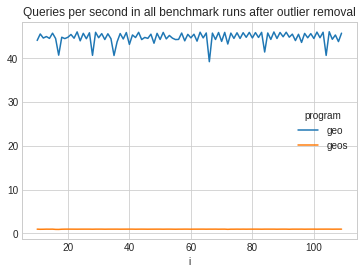

## Ratio of qps compared to geo
                qps
program        geos
count    100.000000
mean       0.021022
std        0.000653
min        0.019980
25%        0.020603
50%        0.020906
75%        0.021229
max        0.024092


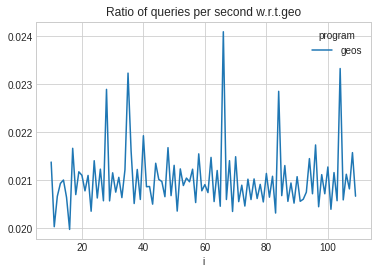

## Ratio of qps compared to geos
                qps
program         geo
count    100.000000
mean      47.611364
std        1.390592
min       41.507048
25%       47.105822
50%       47.832741
75%       48.536409
max       50.049679


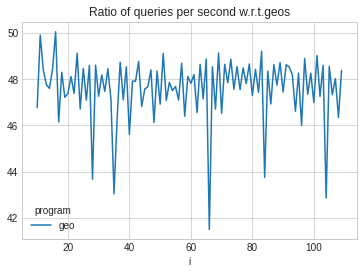

In [1]:
import os
data_absolute_path = os.path.join(os.getcwd(), 'data.json')
%run ../common/benchmark_analysis.ipynb

# Performance benchmarking

To generate the following SVG:

```bash
cd harness
cargo build --release

perf record -F 100 -g --call-graph dwarf -o ../analysis/benchmark_centroid/perf.data -- ./target/release/benchmark_centroid --geojson-file ../data/india_districts/polbnda_ind.geojson --out-file /dev/null --iterations 10 --headlong >/dev/null

cd ../analysis/benchmark_centroid
perf script -i perf.data | ../../third_party/stackcollapse-perf.pl > perf.collapsed-stacks.data
../../third_party/flamegraph.pl perf.collapsed-stacks.data > perf.svg
```

![](./perf.svg)

To dig in further, use
```
perf report -i perf.data --call-graph=fractal,0.5
```

# Vectors && sqrt

* most of the overhead in geos is from slower vector indexing operator compared to rust iterators
* A sizable percent is due to sqrt in distance computation -- the algorithm in geo avoids this entirely.

![](./geo_centroid.png)
![](./geos_centroid.png)

# Uber-optimized

When building without debug info, gcc -O3 is used. This makes geos faster.

```bash
LD_LIBRARY_PATH="${LD_LIBRARY_PATH}:/mnt/data/source/explore-georust/third_party/lib/geos/release" target/release/benchmark_centroid --out-file ../analysis/benchmark_centroid/data-nodbg.json --geojson-file ../data/india_districts/polbnda_ind.geojson --headlong --iterations 120
```

### Loading data from /mnt/data/source/explore-georust/analysis/benchmark_centroid/data-nodbg.json
### Statistics: Raw data
                qps            
program         geo        geos
count    110.000000  110.000000
mean      44.970885    3.830075
std        0.828385    0.104001
min       42.782398    3.263981
25%       44.292141    3.847805
50%       44.827747    3.863928
75%       45.830683    3.875467
max       46.052989    3.898170


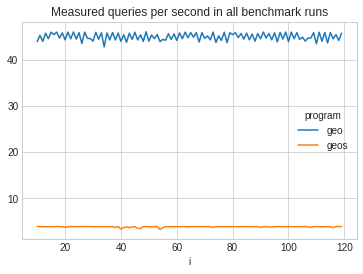

### Statistics: After outlier removal
                qps            
program         geo        geos
count    105.000000  105.000000
mean      45.013963    3.846632
std        0.802936    0.055914
min       43.446379    3.644456
25%       44.308015    3.849981
50%       44.897417    3.863978
75%       45.834518    3.876209
max       46.052989    3.898170


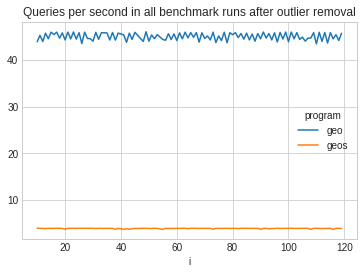

## Ratio of qps compared to geo
                qps
program        geos
count    105.000000
mean       0.085480
std        0.001945
min        0.080160
25%        0.084187
50%        0.085081
75%        0.087058
max        0.089312


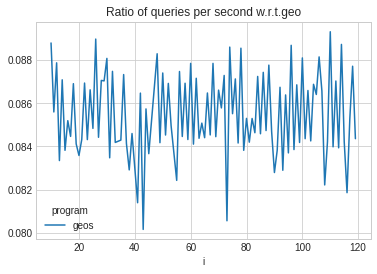

## Ratio of qps compared to geos
                qps
program         geo
count    105.000000
mean      11.704599
std        0.267424
min       11.196658
25%       11.486655
50%       11.753455
75%       11.878373
max       12.475102


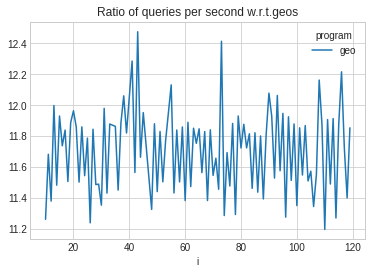

In [2]:
import os
data_absolute_path = os.path.join(os.getcwd(), 'data-nodbg.json')
%run ../common/benchmark_analysis.ipynb